In [1]:
import os
import time
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score

from convolutional_ar.model import ConvolutionalAR

# Convolutional Autoregressive Model

In [2]:
# Load data
#   link to download: http://www.robots.ox.ac.uk/~vgg/research/texclass/
base_dir = "datasets/curet/curetgrey"
f = os.listdir(base_dir)

X = []
y = []

for i in range(1, 62):
    sample_dir = f"{base_dir}/sample{str(i).zfill(2)}"
    for f in os.listdir(sample_dir):
        X.append(torchvision.io.read_image(f"{sample_dir}/{f}")[0])
        y.append(i-1)

X = torch.stack(X).float()
y = np.array(y)

In [3]:
vectors = []

for i in [1, 2, 3, 4, 5]:

    # Decimate
    X_sub = X[:, ::i, ::i]

    # Normalize
    X_sub = (X_sub - X_sub.mean(axis=(1, 2)).reshape(len(X_sub), 1, 1)) / \
        X_sub.std(axis=(1, 2)).reshape(len(X_sub), 1, 1)

    # Fit
    car = ConvolutionalAR(4, verbose=None, n_epochs=50, lr=0.1, loss_fn=torch.nn.L1Loss())
    car.fit(X_sub, progress=lambda i: tqdm(i, total=len(X_sub)))
    
    vectors.append(car.weight_vector_.numpy())

# Save
vectors = np.column_stack(vectors)
np.save("vectors_curet_epoch-50.npy", vectors)

  0%|          | 0/5612 [00:00<?, ?it/s]

  0%|          | 0/5612 [00:00<?, ?it/s]

  0%|          | 0/5612 [00:00<?, ?it/s]

  0%|          | 0/5612 [00:00<?, ?it/s]

  0%|          | 0/5612 [00:00<?, ?it/s]

In [19]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(vectors, y, train_size=0.9)

# Normalize
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

# Fit SVM
svc = SVC(C=1e1, probability=True)
svc.fit(X_train, y_train)

# Accuracy
print('Train Accuracy: ', (svc.predict(X_train) == y_train).sum() / len(y_train))
print('Test  Accuracy: ', (svc.predict(X_test) == y_test).sum() / len(y_test))

Train Accuracy:  0.9998019801980198
Test  Accuracy:  0.9306049822064056


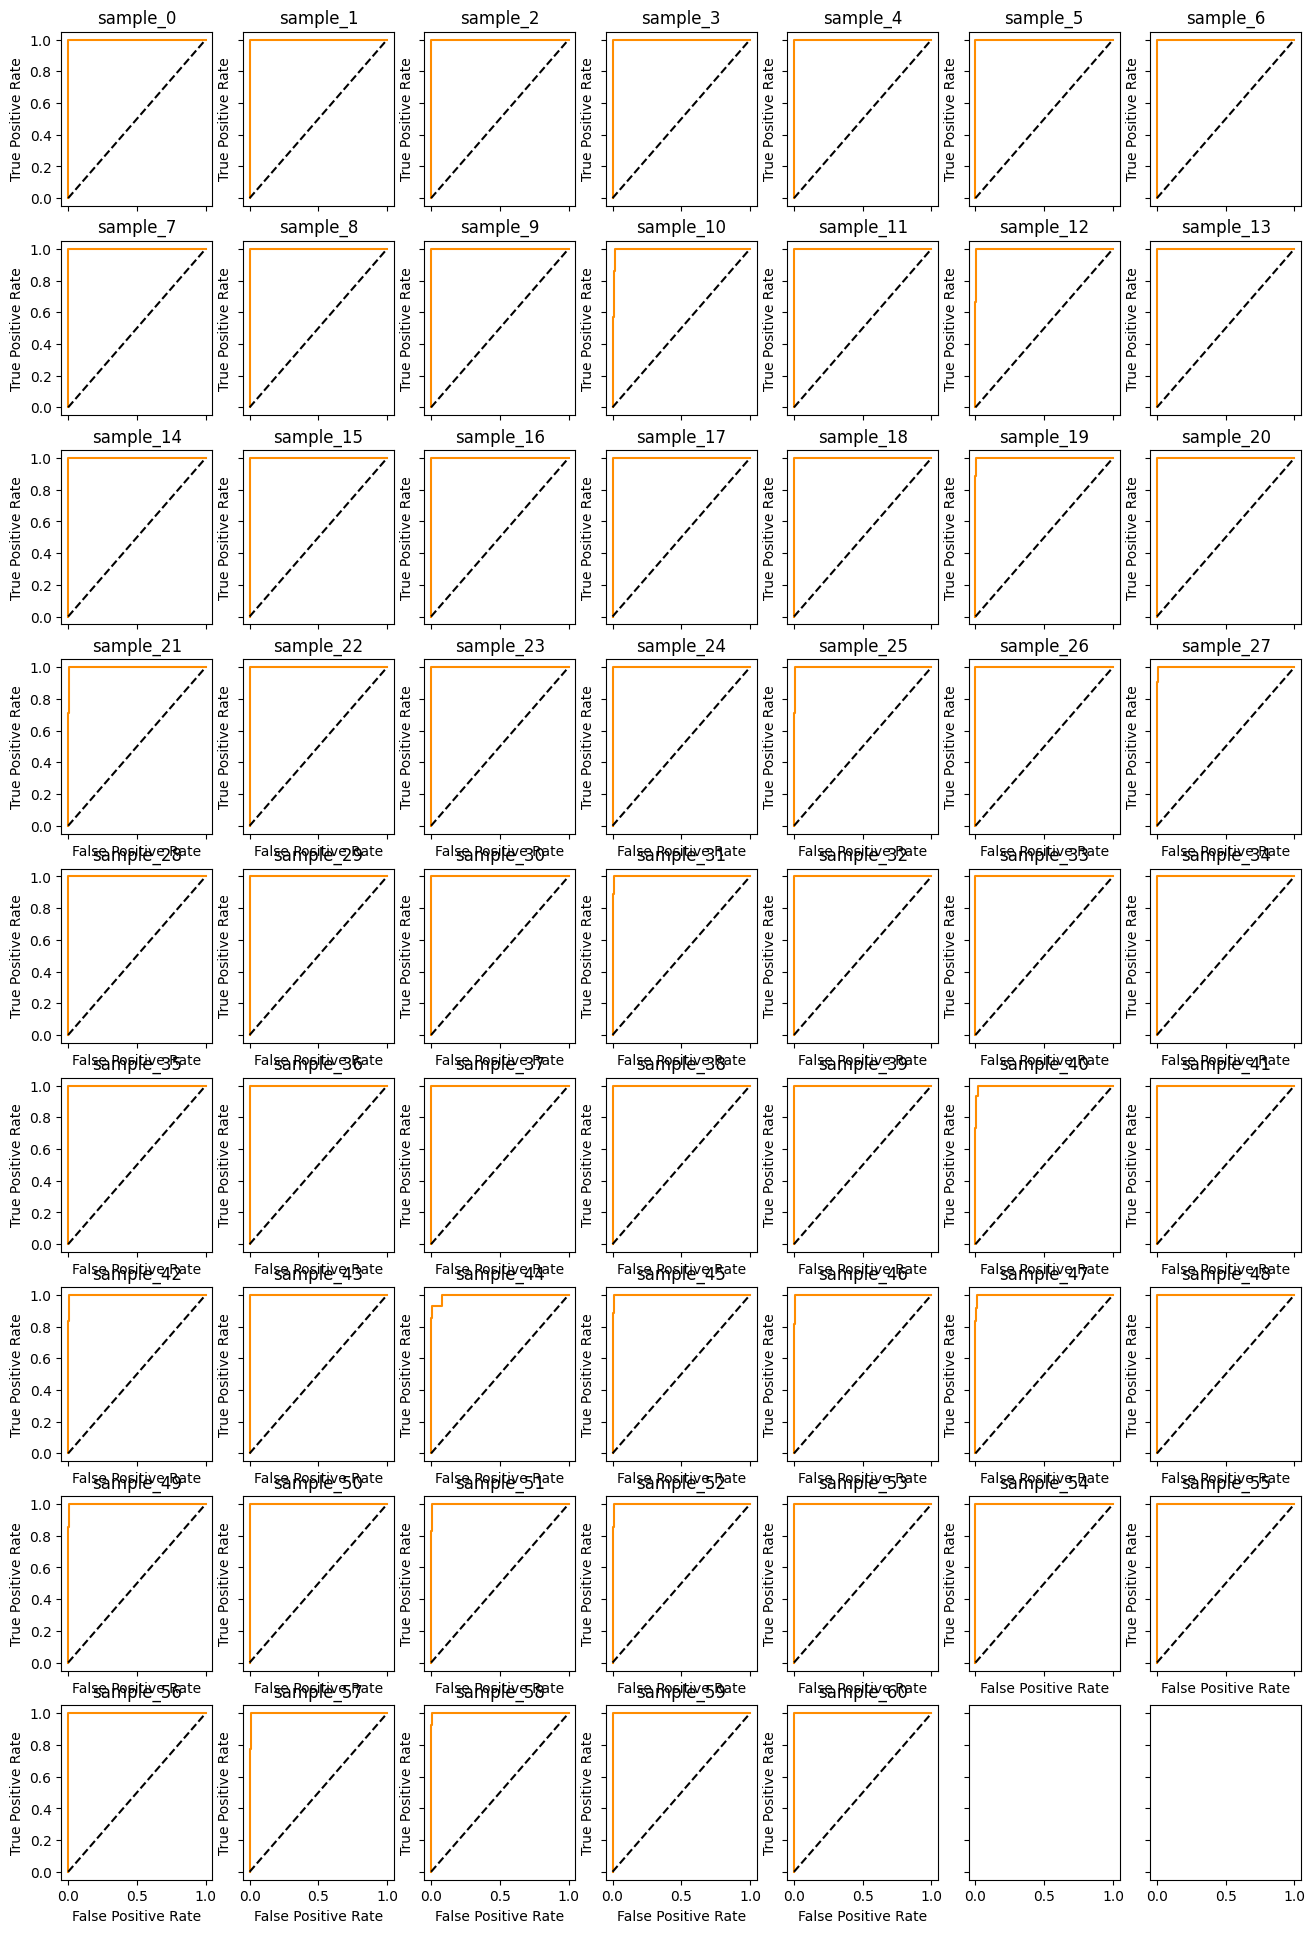

In [20]:
classes = {f"sample_{i}": i for i in range(61)}

# Plot examples
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)

y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

y_score = svc.predict_proba(X_test)

fig, axes = plt.subplots(nrows=9, ncols=7, figsize=(16, 24), sharex=True, sharey=True)
axes = axes.flatten()

for c in classes.keys():
    i = classes[c]

    RocCurveDisplay.from_predictions(
        y_onehot_test[:, i],
        y_score[:, i],
        name=f"{c} vs the rest",
        color="darkorange",
        plot_chance_level=True,
        ax=axes[i]
    )
    axes[i].set_ylabel("True Positive Rate")
    if i > 20:
        axes[i].set_xlabel("False Positive Rate") 
    else:
        axes[i].set_xlabel("")
    axes[i].get_legend().remove()
    axes[i].set_title(f"{c}")